In [1]:
import os
import sys
import math
import logging
import structlog
from pathlib import Path
import json

import tomli
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12, 6.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

In [2]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [3]:
import pytanis
from pytanis import GSheetClient, PretalxClient
from pytanis.pretalx import subs_as_df
from pytanis.review import read_assignment_as_df, save_assignments_as_json, Col

In [4]:
# Be aware that this notebook might only run with the following version
pytanis.__version__ 

'0.1.1.post1.dev7+g70b95f1.d20230118'

In [5]:
# Import event-specific settings to don't have them here in the notebook
with open('config.toml', 'rb') as fh:
    cfg = tomli.load(fh)
    
TARGET_REVIEWS = 3  # We want at least 3 reviews per proposal
RND_STATE = 1729 # Random state or None for really random
community_map = "General: Community, Diversity, Career, Life and everything else", "General: Community" # to make splitting easier in GSheet

# Read Reviews and all Submissions

In [6]:
pretalx_client = PretalxClient(blocking=True)
subs_count, subs = pretalx_client.submissions(cfg['event_name'])
revs_count, revs = pretalx_client.reviews(cfg['event_name'])
subs, revs = list(subs), list(revs)

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

In [7]:
# count reviews that actually have scores
revs_vcounts = pd.Series([r.submission for r in revs if r.score is not None]).value_counts()
revs_vcounts = revs_vcounts.reset_index().rename(columns={"index": Col.submission, 0: Col.nreviews})
# keep track of all reviews, i.e. proposals people interacted with
revs_df_raw = pd.DataFrame([{"created": r.created, "updated": r.updated, Col.pretalx_user: r.user, "score": r.score, "review": r.submission} for r in revs])
revs_df = revs_df_raw.groupby([Col.pretalx_user]).agg(lambda x: x.tolist()).reset_index()

In [8]:
subs_df = subs_as_df([sub for sub in subs if sub.state == "submitted"])  # Take only submitted ones
subs_df[Col.track].replace(dict([community_map]), inplace=True)
subs_df[Col.target_nreviews] = TARGET_REVIEWS  
subs_df = pd.merge(subs_df, revs_vcounts, on=Col.submission, how='left')
subs_df[Col.nreviews] = subs_df[Col.nreviews].fillna(0).astype(int)
subs_df[Col.rem_nreviews] = (subs_df[Col.target_nreviews] - subs_df[Col.nreviews]).map(lambda x: max(0, x))

In [9]:
# save all submission codes for later
all_sub_codes = list(subs_df[Col.submission])

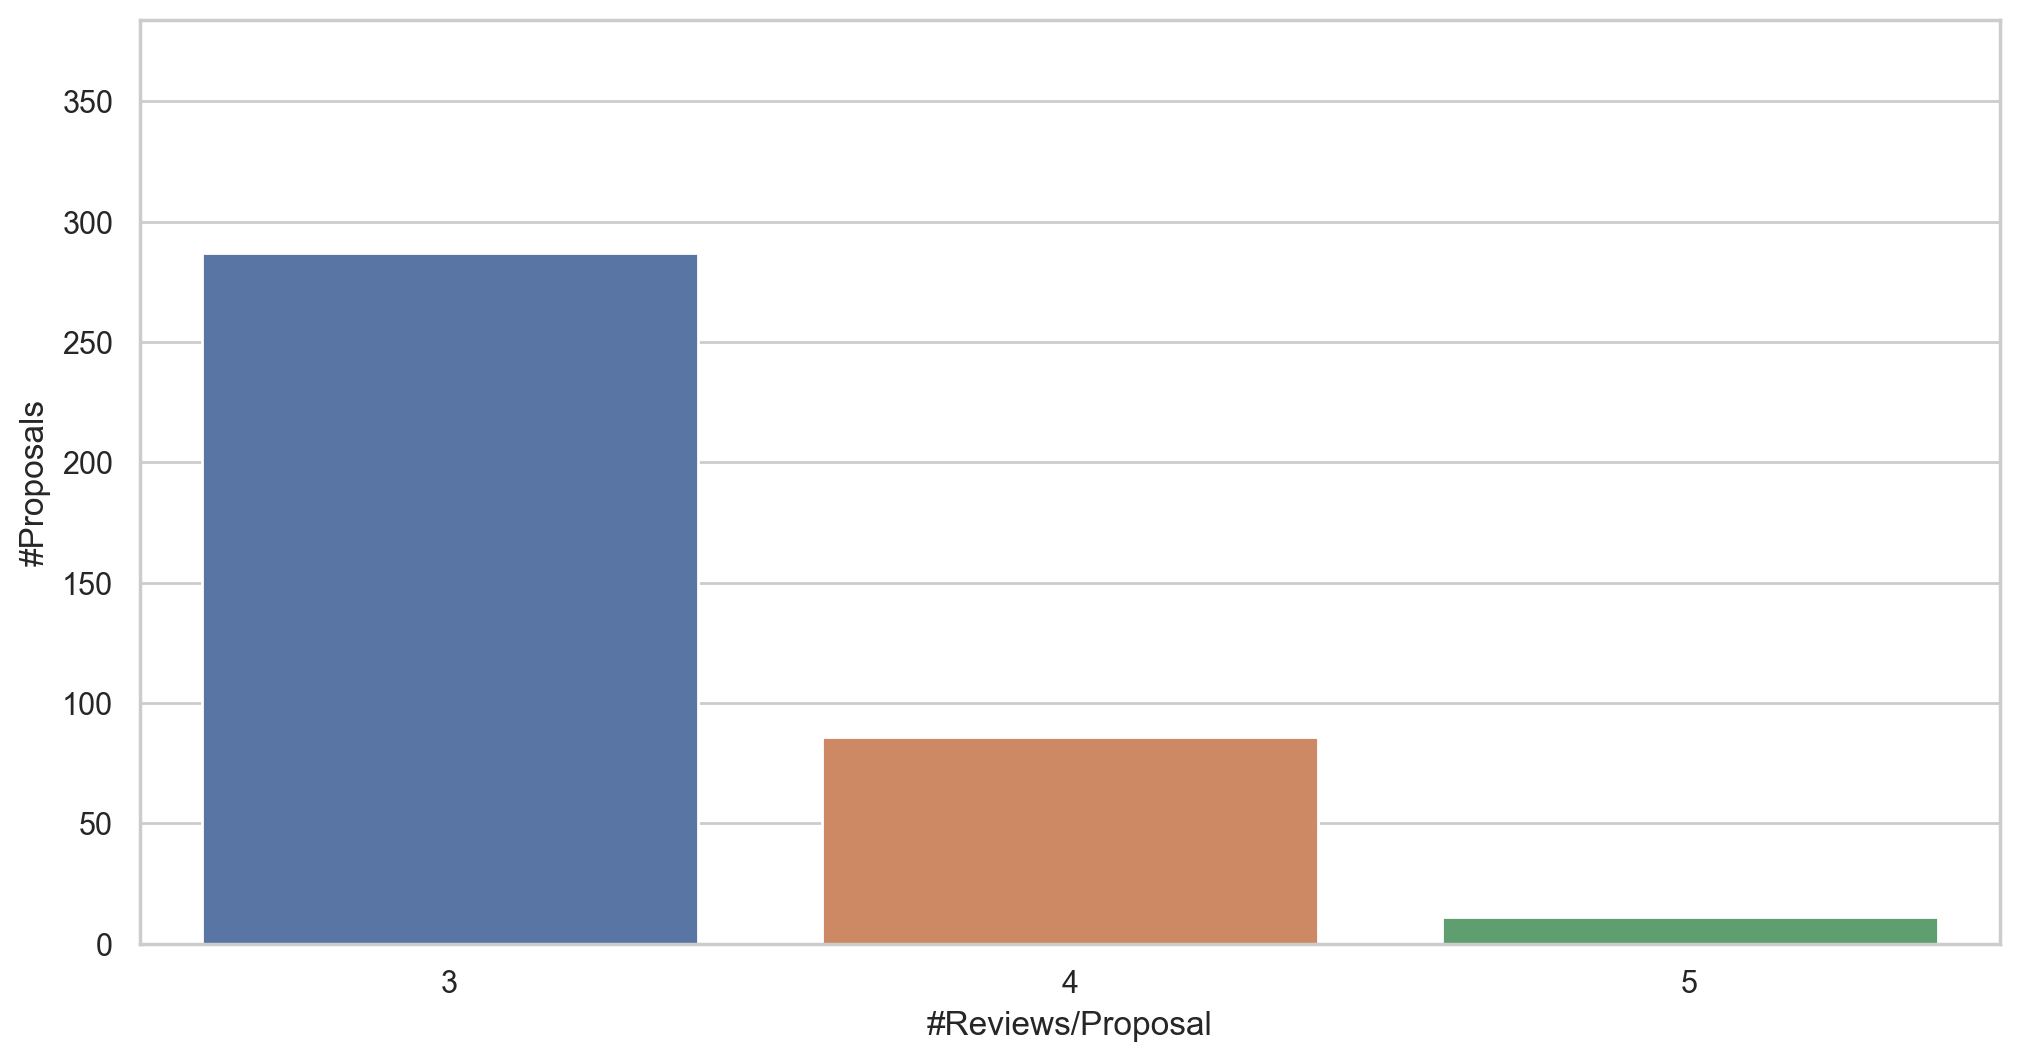

In [10]:
bp = sns.barplot(subs_df[Col.nreviews].value_counts().reset_index().rename(columns={'index': '#Reviews/Proposal', Col.nreviews: "#Proposals"}), 
                 x='#Reviews/Proposal', y="#Proposals")
bp.set(ylim=(0, len(subs_df.index)));

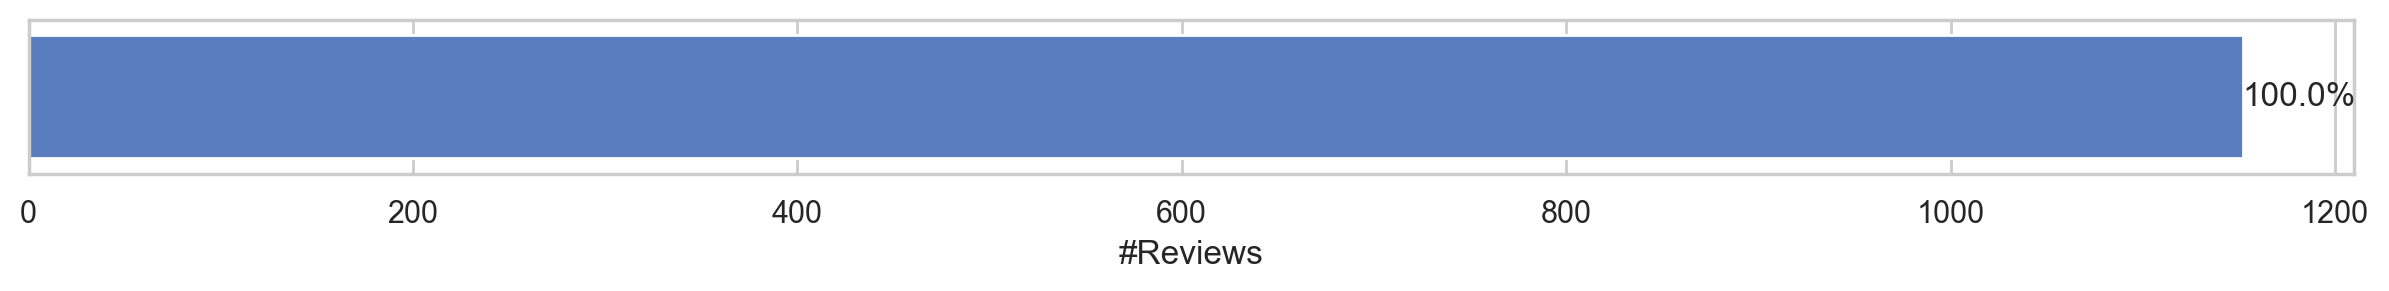

In [11]:
progress_df = subs_df.copy()
progress_df[Col.nreviews] = progress_df[Col.nreviews].map(lambda x: min(x, TARGET_REVIEWS)) # map more than 3 reviews to 3
progress_df = progress_df[[Col.target_nreviews, Col.nreviews]].sum().to_frame().T
f, ax = plt.subplots(figsize=(15, 1))
sns.set_color_codes("pastel")
sns.barplot(data=subs_df[[Col.target_nreviews, Col.nreviews]].sum().to_frame().T, x=Col.target_nreviews, color='b')
sns.set_color_codes("muted")
ax = sns.barplot(data=progress_df, x=Col.nreviews, color='b');
ax.bar_label(ax.containers[1], labels=["{:.1%}".format(progress_df.loc[0, Col.nreviews] / progress_df.loc[0, Col.target_nreviews])]);

# Get spreadsheat with reviewers and preferences

In [12]:
gsheet_client = GSheetClient()

In [13]:
gsheet_df = gsheet_client.gsheet_as_df(cfg['spreadsheet_id'], cfg['worksheet_name'])
# rename columns to stick to our convention
col_map = {
 "Topics you want to review": Col.track_prefs,
 "Email address": Col.email,
 "Name": Col.speaker_name,
 "Affiliation": Col.affiliation,
 "Who do you know from the Committee?": Col.committee_contact,
 "Availability during the Review Period": Col.availability,
 "Additional comments regarding your availability during the review period.": Col.availability_comment,
 "Activated in Pretalx": Col.pretalx_activated,
 "Do you want your name to be listed as a reviewer on the conference website?": Col.public,
 "Wants all proposals": Col.all_proposals,
 "Any additional comments for the Program Committee": Col.comment,
 "Pretalx Name": Col.pretalx_user,
}
gsheet_df.rename(columns=col_map, inplace=True)

### Do some transformations to handle the GSheet

In [14]:
# parse preferences
gsheet_df[Col.track_prefs] = gsheet_df[Col.track_prefs].apply(lambda x: x.replace(community_map[0], community_map[1]).split(', '))
gsheet_df = gsheet_df.loc[~gsheet_df[Col.pretalx_activated].isna()]
# save people that want all proposals for later
assign_all_emails = gsheet_df[Col.email].loc[gsheet_df[Col.all_proposals] == 'x'].tolist()
gsheet_df = gsheet_df.loc[gsheet_df[Col.all_proposals] != 'x']

In [15]:
assign_df = pd.merge(gsheet_df, revs_df, on=Col.pretalx_user, how='left')
assign_df["review"] = assign_df["review"].apply(lambda x: x if isinstance(x, list) else [])
assign_df[Col.curr_assignments] = assign_df["review"].map(lambda x: x[:])

In [16]:
assign_df = assign_df.assign(**{Col.done_nreviews: assign_df["score"].map(
    lambda scores: 0 if not isinstance(scores, list) else len([s for s in scores if not np.isnan(s)]))}
)

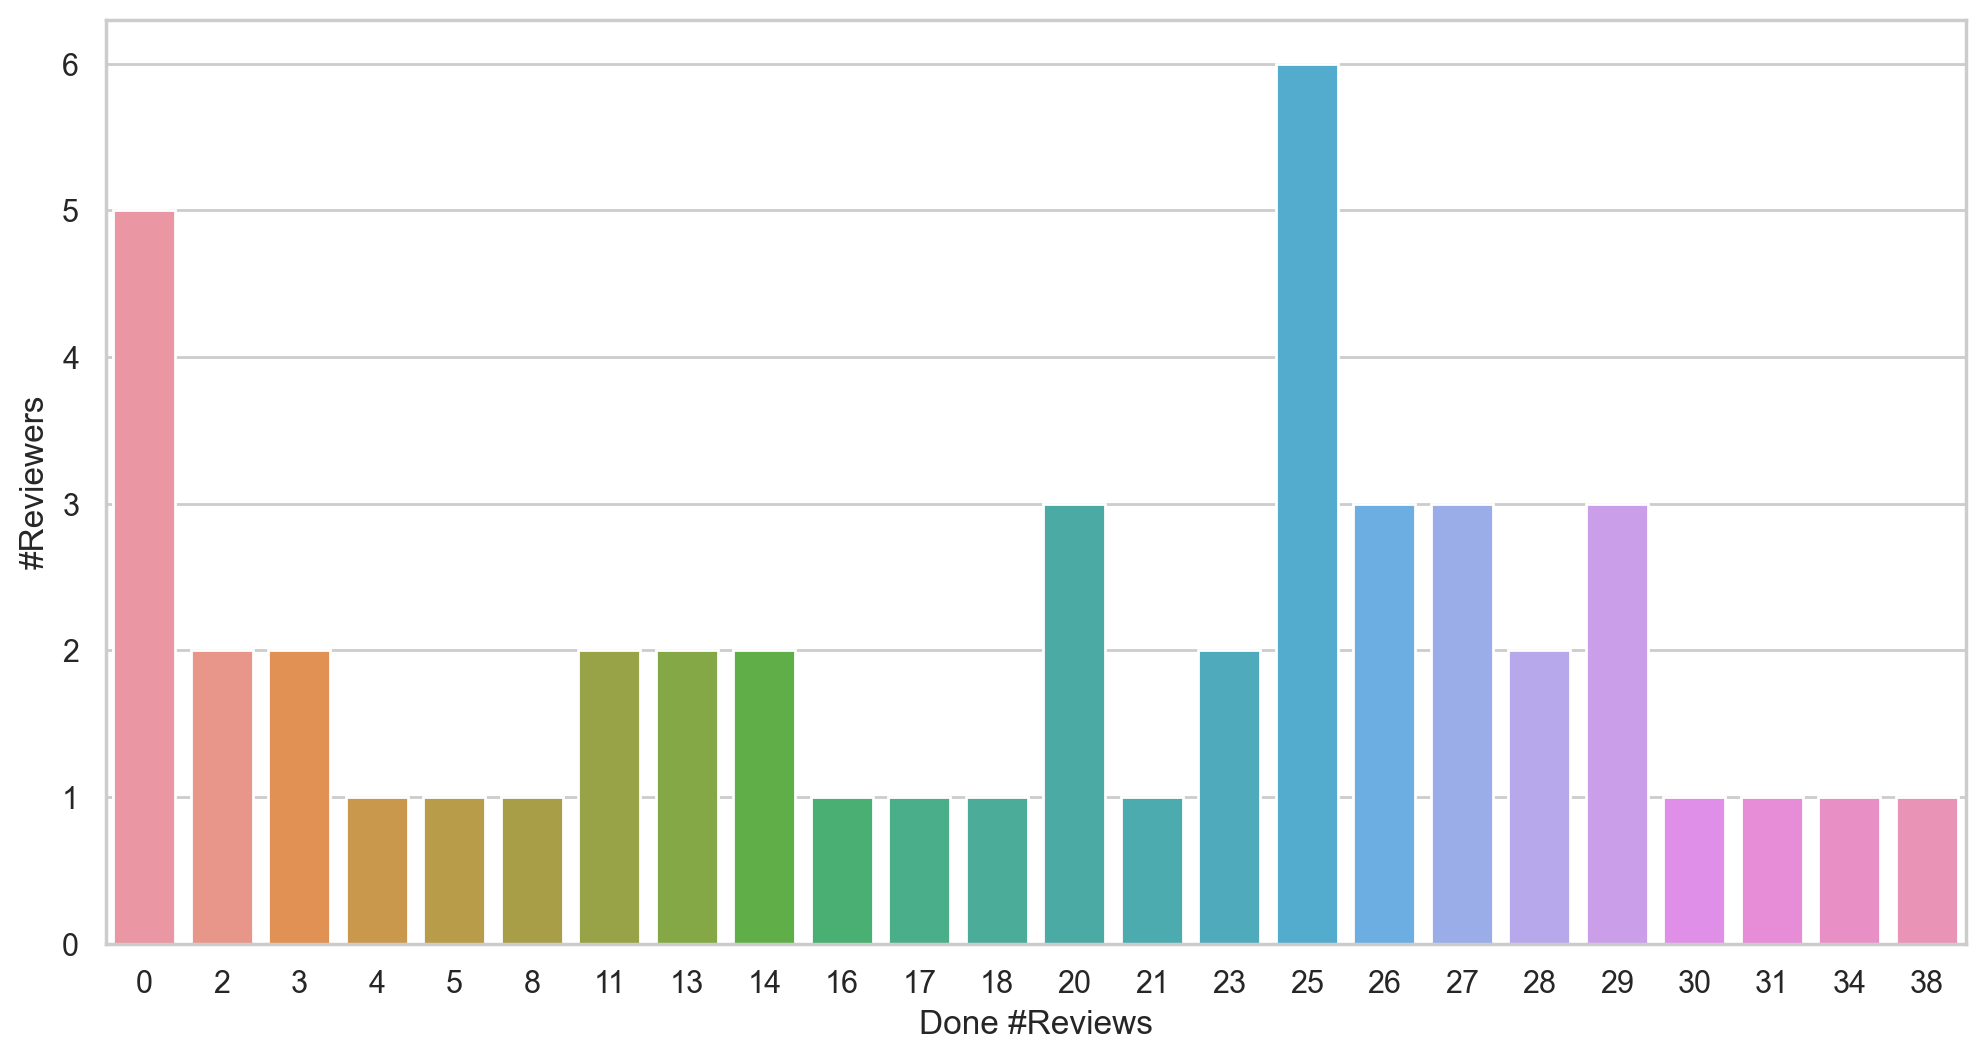

In [17]:
sns.barplot(assign_df[Col.done_nreviews].value_counts().reset_index().rename(
    columns={'index': Col.done_nreviews, Col.done_nreviews: "#Reviewers"}), 
    x=Col.done_nreviews, 
    y="#Reviewers");

In [18]:
active_rev = pd.DataFrame({
    "Active Reviewers": [assign_df.assign(started=assign_df[Col.done_nreviews] > 0).groupby("started").count()[Col.speaker_name].loc[True]],
    "all": [len(assign_df)]
})

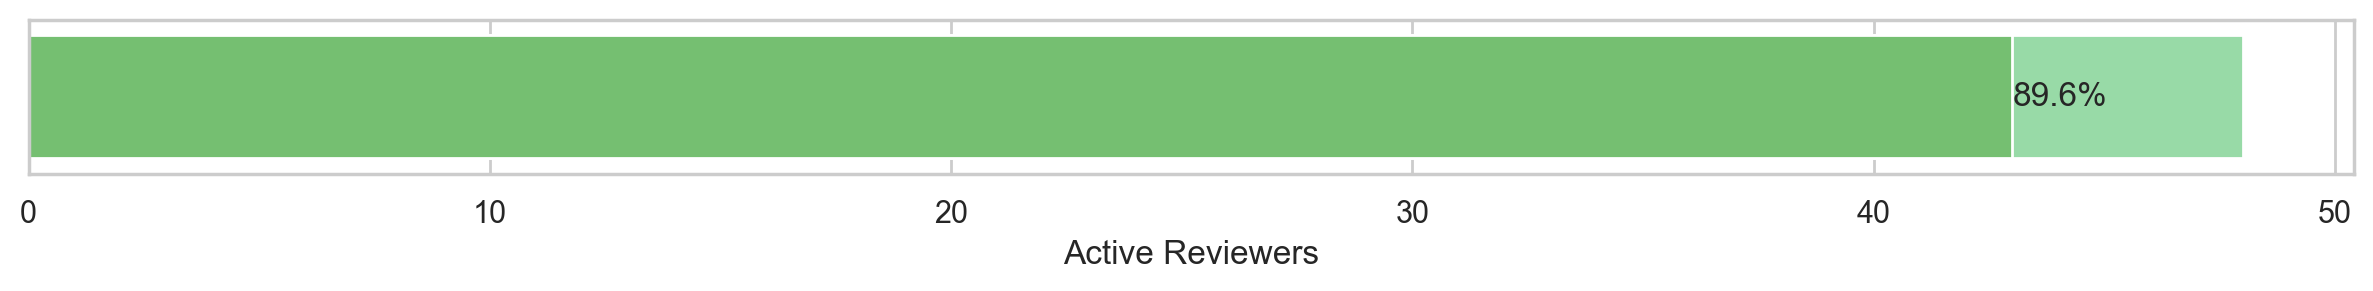

In [19]:
f, ax = plt.subplots(figsize=(15, 1))
sns.set_color_codes("pastel")
sns.barplot(data=active_rev, x="all", color='g')
sns.set_color_codes("muted")
ax = sns.barplot(data=active_rev, x="Active Reviewers", color='g');
ax.bar_label(ax.containers[1], labels=["{:.1%}".format(active_rev.loc[0, "Active Reviewers"] / active_rev.loc[0, "all"])]);

# Assign remaining proposals to reviewers

The main idea is to assign each the number of needed reviews plus a buffer for a proposal/submission: 
* not a person having already assigned the review for a submission (no duplicates)
* to a person having a preference for the track with the least amount of current work.
* if no person has a preference for the track of the proposal, assign to someone with not much work.

Since we will run this dynamically the moment the needed number is reached, the proposal will be deallocated from people that were assigned the buffer.

(it might be that someone gets by accident assigned his/her own proposal but Pretalx takes care of that if the same user e-mail was used)

In [20]:
def find_user(df, is_preference, is_already_assigned):
    mask = is_preference & ~is_already_assigned
    if df.loc[mask].empty:
        return df.loc[~is_already_assigned, "New Assignments"].idxmin()
    else:
        return df.loc[mask, "New Assignments"].idxmin()

def assign_proposals(dist_df, curr_df, buffer=3):
    dist_df = dist_df.sort_values(Col.rem_nreviews, ascending=False)
    curr_df = curr_df.copy()
    for _, row in dist_df.iterrows():
        is_preference = curr_df[Col.track_prefs].map(lambda x: row[Col.track] in x)
        is_already_assigned = curr_df[Col.curr_assignments].map(lambda x: row[Col.submission] in x)
        if row[Col.rem_nreviews] < 1:
            continue
        for _ in range(row[Col.rem_nreviews] + buffer):
            idx = find_user(curr_df, is_preference, is_already_assigned)
            curr_df.loc[idx, Col.curr_assignments].append(row[Col.submission])
            curr_df.loc[idx, "New Assignments"] += 1
    return curr_df

In [21]:
#assign_df["New Assignments"] = assign_df[Col.curr_assignments].map(len) # keep track of what was done so far
#start giving everyone some more things to do
assign_df["New Assignments"] = 0

assign_df = assign_df.sample(frac=1, random_state=RND_STATE).reset_index(drop=True)
new_assign_df = assign_proposals(subs_df, assign_df)

In [22]:
# add people that want all proposals assigned again
all_subs_df = pd.DataFrame({Col.email: assign_all_emails, Col.curr_assignments: [all_sub_codes] * len(assign_all_emails)})
new_assign_df = pd.concat([new_assign_df, all_subs_df]).reset_index()

# Save it as JSON

In [23]:
save_assignments_as_json(new_assign_df, "assignments_20230131_1.json")